In [10]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from trunc_censoring_aborts_utils import rho_A_t_fn, cum_A_t_fn
import corner
from scipy.integrate import trapezoid as trapz

# data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# LED on or off

In [3]:
LED_TRIAL = 0

df_to_fit = df[ df['LED_trial'] == LED_TRIAL ] 

# VBMC

In [4]:
T_trunc = 0.3

## likelihood

In [ ]:
def compute_loglike(row, V_A, theta_A, t_A_aff, pdf_trunc_factor):
    t_stim = row['intended_fix']
    rt = row['timed_fix']

    if rt < T_trunc:
        likelihood = 0
    else:
        if rt < t_stim:
            likelihood =  rho_A_t_fn(rt - t_A_aff, V_A, theta_A) / pdf_trunc_factor
        elif rt > t_stim:
            if t_stim <= T_trunc:
                likelihood = 1
            else:
                likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) ) / pdf_trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, V_A, theta_A)
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A, theta_A, t_A_aff, pdf_trunc_factor) \
                                       for _, row in df_to_fit.iterrows() if (not np.isnan(row['timed_fix'] + row['intended_fix']) ))
                                   


    loglike = np.sum(all_loglike)
    return loglike

## bounds

In [6]:
V_A_bounds = [0.1, 5]
theta_A_bounds = [0.1, 5]
t_A_aff_bounds = [-5, 0.1]

V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [-2, 0.06]

## prior

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A,t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

## prior + likelihood

In [8]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

## run vbmc

In [9]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, t_A_aff_0])


In [10]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).


/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 7. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 6. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/hom

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -241136.657 +/-0.000.


## save

In [ ]:
# vp.save(f'trunc_and_censor_fit_aborts_LED_{LED_TRIAL}.pkl', overwrite=True)

In [5]:
import pickle
with open('LED_OFF_VBMC_LT_RC_VP_DATA_0.pkl', 'rb') as f:
    vp = pickle.load(f)

# Diagnostics

## corner

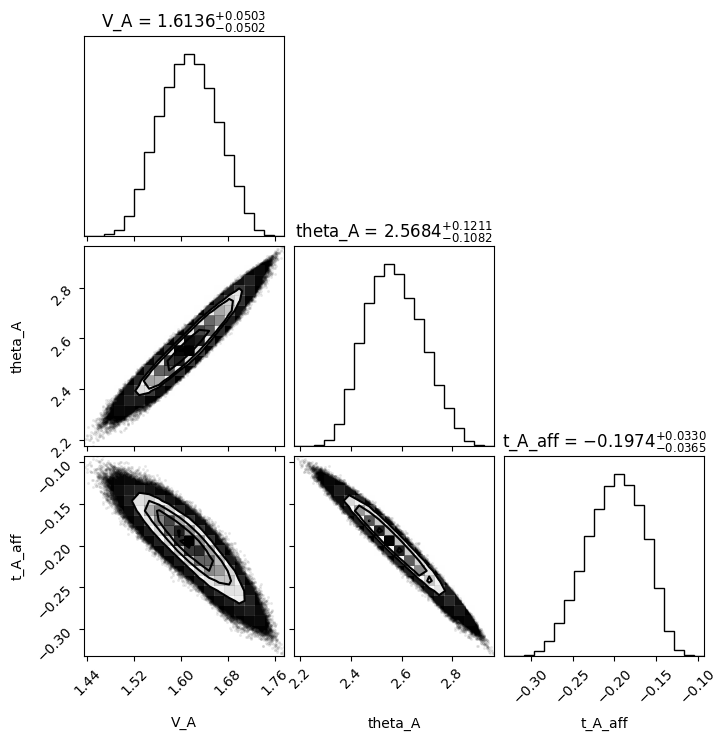

In [6]:
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f" );


# fit and see

In [13]:
# plotting params

bw_data = 0.05
bins_data = np.arange(0, 2, bw_data)
t_pts_data = bins_data[:-1] + bw_data/2


bw_theory = 0.01
bins_theory = np.arange(0, 2, bw_theory)
t_pts_theory  = bins_theory[:-1] + bw_theory/2



# data aborts

In [26]:
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values
frac_of_aborts = len(data_abort_rt)/len(df_to_fit)
print(f'frac of aborts: {frac_of_aborts}')

frac of aborts: 0.12307854921027996


# trunc pdf abort fn

In [14]:
# theory
def pdf_abort_trunc_fn(t, t_stim, V_A, theta_A, t_A_aff, trunc_factor):
    if t <= T_trunc or t >= t_stim:
        pdf = 0
    else:
        pdf = rho_A_t_fn(t - t_A_aff, V_A, theta_A) / trunc_factor

    return pdf

## sample t_stim and calc pdf for each t_stim

In [20]:
V_A_samp_mean = np.mean(V_A_samp); theta_A_samp_mean = np.mean(theta_A_samp); t_A_aff_samp_mean = np.mean(t_A_aff_samp)


M = 50000
t_stim_all = df_to_fit['intended_fix'].values
t_stim_sample = random.choices(t_stim_all, k=M)


pdf_theory = np.zeros((M, len(t_pts_theory)))
cdf_theory = np.zeros((M,))
area_pdf_theory = np.zeros((M,))

trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_samp_mean, V_A_samp_mean, theta_A_samp_mean)

for i,t_stim in tqdm(enumerate(t_stim_sample)):
    pdf_theory[i, :] = [pdf_abort_trunc_fn(t, t_stim, V_A_samp_mean, theta_A_samp_mean, t_A_aff_samp_mean, trunc_factor) for t in t_pts_theory]
    cdf_theory[i] = cum_A_t_fn(t_stim - t_A_aff_samp_mean, V_A_samp_mean, theta_A_samp_mean) / trunc_factor
    area_pdf_theory[i] = trapz(pdf_theory[i, :], t_pts_theory)

0it [00:00, ?it/s]

50000it [00:02, 17060.54it/s]


# checks - area of pdf, area of aborts

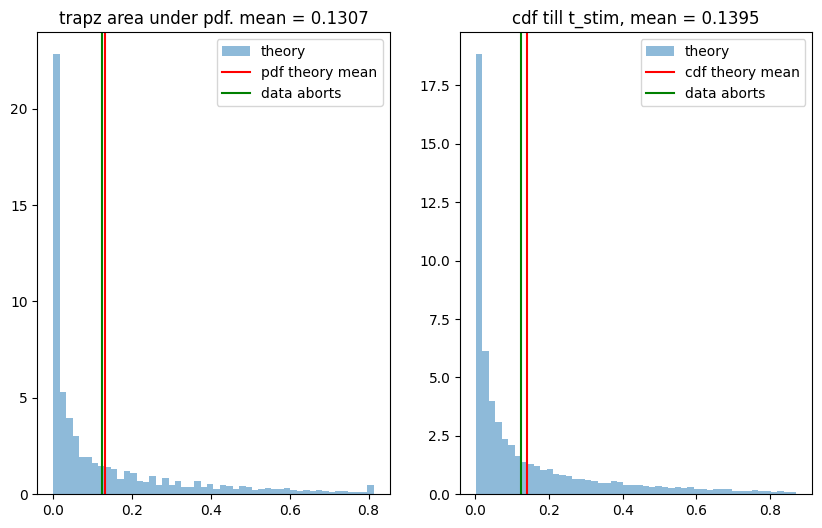

In [27]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(area_pdf_theory, bins=50, density=True, alpha=0.5, label='theory')
area_pdf_theory_mean = np.mean(area_pdf_theory)
plt.axvline(area_pdf_theory_mean, color='r', label='pdf theory mean')
plt.axvline(frac_of_aborts, color='g', label='data aborts')
plt.title(f'trapz area under pdf. mean = {area_pdf_theory_mean:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cdf_theory, bins=50, density=True, alpha=0.5, label='theory')
cdf_theory_mean = np.mean(cdf_theory)
plt.title(f'cdf till t_stim, mean = {cdf_theory_mean:.4f}')
plt.axvline(cdf_theory_mean, color='r', label='cdf theory mean')
plt.axvline(frac_of_aborts, color='g', label='data aborts')
plt.legend()

# compare theory with data

frac of aborts: 0.12307854921027996


Text(0.5, 1.0, 'LED OFF, LTRC, area theory=0.131, area data =  0.123')

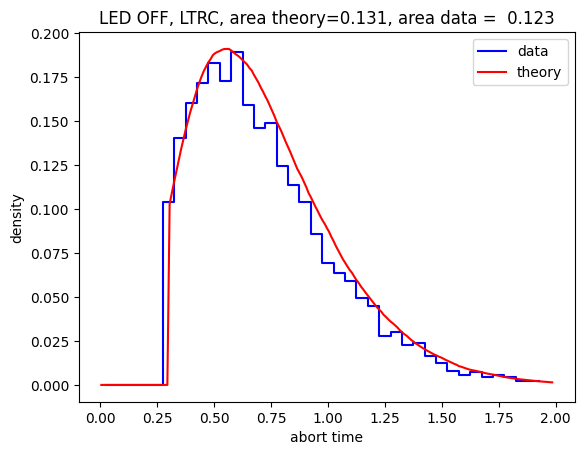

In [ ]:
data_hist, _ = np.histogram(data_abort_rt, bins=bins_data, density=True)
data_hist *= frac_of_aborts

# theory
pdf_theory_mean = np.mean(pdf_theory, axis=0)

plt.step(t_pts_data, data_hist, label='data', color='b')
plt.plot(t_pts_theory, pdf_theory_mean, label='theory', color='r')
plt.legend()

plt.xlabel('abort time'); plt.ylabel('density')
plt.title(f'LED OFF, LTRC, area theory={trapz(pdf_theory_mean, t_pts_theory):.3f}, area data =  {trapz(data_hist, t_pts_data):.3f}')
